In [53]:
import os
import pandas as pd
import numpy as np
import re
from datetime import datetime
import pickle
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from scipy import signal

In [ ]:
input_directory = r"experiment4"
# r"C:\Users\colin\Desktop\DataDownloads\CompanyCollection\tatsuo_cases_2025_04"

def generate_combined_df(input_directory, sensor_df):
    if os.path.exists(os.path.join(input_directory, "bench")): # TODO added this line becasue my download didnt have bench as path
        input_directory = os.path.join(input_directory, "bench") # TODO seems like I should have had bench as part of path

    fsr_filename_pattern = re.compile(
        r"fsr_(?P<device_id>[^_]+)_(?P<participant_id>[^_]+)_(?P<trial>\d+)_"  # device + participant + trial
    r"(?P<year>\d{4})_(?P<month>\d{2})_(?P<day>\d{2})_"
    r"(?P<hour>\d{2})_(?P<minute>\d{2})_(?P<second>\d{2})_(?P<millisecond>\d{6})\.csv"
    )

    # Load FSR timestamps
    fsr_files = {}
    for fsr_file in os.listdir(input_directory):
        match = fsr_filename_pattern.match(fsr_file)
        if match:
            fsr_timestamp_str = f"{match['year']}-{match['month']}-{match['day']} " \
                                f"{match['hour']}:{match['minute']}:{match['second']}." \
                                f"{match['millisecond']}"
            fsr_timestamp = datetime.strptime(fsr_timestamp_str, "%Y-%m-%d %H:%M:%S.%f")
            fsr_files[fsr_timestamp] = fsr_file

    combined_data = []

    for _, row in sensor_df.iterrows():
        timestamp = row["Timestamp"]

        # Find the closest FSR file within ±5 seconds
        closest_fsr_time = min(
            (fsr_time for fsr_time in fsr_files.keys()
             if abs((fsr_time - timestamp).total_seconds()) <= 5),
            key=lambda t: abs((t - timestamp).total_seconds()),
            default=None
        )

        fsr_time_list, fsr_timestamp_list, fsr_force_list = [], [], []

        if closest_fsr_time:
            fsr_path = os.path.join(input_directory, fsr_files[closest_fsr_time])
            try:
                fsr_df = pd.read_csv(fsr_path, skiprows=1, names=["timediff", "timestamp", "force"])
                fsr_time_list = fsr_df["timediff"].tolist()
                fsr_timestamp_list = fsr_df["timestamp"].tolist()
                fsr_force_list = fsr_df["force"].tolist()
            except Exception as e:
                print(f"Error reading FSR file {fsr_files[closest_fsr_time]}: {e}")

        # Append row with or without FSR data
        row["FSR TimeDiff List"] = fsr_time_list
        row["FSR Timestamp List"] = fsr_timestamp_list
        row["FSR Force List"] = fsr_force_list
        row["FSR Timestamp"] = closest_fsr_time

        combined_data.append(row)

    df = pd.DataFrame(combined_data)

    modality_dataframes = {}
    # if not df.empty:
    #     for modality, modality_df in df.groupby("Modality"):
    #         modality_dataframes[modality] = modality_df

    if not df.empty:
        modality_dataframes['data'] = df
    return modality_dataframes

def remove_empty_columns(df):
    # Define sensor columns
    sensor_columns = ["Accel X", "Accel Y", "Accel Z", "Gyro X", "Gyro Y", "Gyro Z", "FSR Timestamp List", "FSR Force List"]

    # Remove rows where any sensor column contains an empty list
    df = df[~df[sensor_columns].apply(lambda row: any(len(x) == 0 for x in row), axis=1)]

    return df.reset_index(drop=True)

'''
generate_modality_df processes sensor data text files and organizes them by 
returns a dictionary of Pandas DataFrames per modality.
'''
def generate_modality_df(input_directory):
    if os.path.exists(os.path.join(input_directory, "phone")):
        input_directory = os.path.join(input_directory, "phone")

    filename_pattern2 = re.compile(
        r"(?P<project_name>[^_]+)_"                             # VibroDataCollection
        r"(?P<last_four_phone_id>[^_]+)_"                       # c4a0
        r"(?P<sensor_type>[^_]+)_"                              # accel
        r"(?P<participant_id>[^_]+)_"                           # fullgrip-redcase-tatsuo
        r"(?P<test_duration>\d{1,3})_"                       # 5 (duration in seconds, allow up to 3 digits just in case)
        r"(?P<year>\d{4})_"                                     # 2025
        r"(?P<month>\d{2})_"                                    # 07
        r"(?P<day>\d{2})_"                                      # 11
        r"(?P<hour>\d{2})_"                                     # 10
        r"(?P<minute>\d{2})_"                                   # 54
        r"(?P<second>\d{2})_"                                   # 59
        r"(?P<millisecond>\d{3})\.csv"                          # 175.csv
    )

    # filename_pattern1 = re.compile(
    #     r"(?P<project_name>[^_]+)_(?P<phone_model>[^_]+)_(?P<sensor_type>[^_]+)_(?P<modality>[^_]+)_"
    #     r"(?P<participant_id>[^_]+)?_(?P<trial>\d{1})_(?P<year>\d{4})_(?P<month>\d{2})_(?P<day>\d{2})_"
    #     r"(?P<hour>\d{2})_(?P<minute>\d{2})_(?P<second>\d{2})_(?P<millisecond>\d{3}).txt"
    # )
    
    modality_dataframes = {}

    combined_data = []

    for filename in os.listdir(input_directory):
        match = filename_pattern2.match(filename)
        # if not match:
        #     match = filename_pattern2.match(filename) -> TODO ask Colin what filename_pattern2 is

        if match:
            file_info = match.groupdict()
            participant_id = file_info.get("participant_id")
            test_duration = file_info["test_duration"]
            sensor_type = file_info["sensor_type"]

            datetime_str = f"{file_info['year']}-{file_info['month']}-{file_info['day']} " \
                           f"{file_info['hour']}:{file_info['minute']}:{file_info['second']}." \
                           f"{file_info['millisecond']}"
            file_datetime = datetime.strptime(datetime_str, "%Y-%m-%d %H:%M:%S.%f")

            file_path = os.path.join(input_directory, filename)
            if os.path.isfile(file_path):
                try:
                    content_df = pd.read_csv(file_path)
                    summary = {
                        "Project Name": file_info["project_name"],
                        "Phone Model": file_info["last_four_phone_id"],
                        "Participant ID": participant_id,
                        "Test Duration": test_duration,
                        "Timestamp": file_datetime,
                        "Rounded Timestamp": file_datetime.replace(microsecond=0),  # Round to nearest second
                        # "Time": content_df["time"].tolist()
                    }
                    
                    # Assign sensor-specific data
                    if sensor_type == "accel":
                        summary["Accel X"] = content_df["x"].tolist()
                        summary["Accel Y"] = content_df["y"].tolist()
                        summary["Accel Z"] = content_df["z"].tolist()
                        summary["Gyro X"] = []
                        summary["Gyro Y"] = []
                        summary["Gyro Z"] = []
                        summary["Time"] = content_df["timestamp"].tolist()
                    elif sensor_type == "gyro":
                        summary["Gyro X"] = content_df["x"].tolist()
                        summary["Gyro Y"] = content_df["y"].tolist()
                        summary["Gyro Z"] = content_df["z"].tolist()
                        summary["Accel X"] = []
                        summary["Accel Y"] = []
                        summary["Accel Z"] = []
                        summary["Time"] = content_df["timestamp"].tolist()

                    combined_data.append(summary)
                except Exception as e:
                    print(f"Error reading file {filename}: {e}")

    # Convert list to DataFrame
    df = pd.DataFrame(combined_data)
    if not df.empty:
        # Group by rounded timestamp and modality, merging accel and gyro data
        df = df.groupby(["Rounded Timestamp"]).agg({
            "Project Name": "first",
            "Phone Model": "first",
            "Participant ID": "first",
            "Timestamp": "first",
            "Time": lambda x: sum(x, []),
            "Accel X": lambda x: sum(x, []),
            "Accel Y": lambda x: sum(x, []),
            "Accel Z": lambda x: sum(x, []),
            "Gyro X": lambda x: sum(x, []),
            "Gyro Y": lambda x: sum(x, []),
            "Gyro Z": lambda x: sum(x, [])
        }).reset_index()

        # Remove rows where all sensor columns are empty lists
        sensor_columns = ["Accel X", "Accel Y", "Accel Z", "Gyro X", "Gyro Y", "Gyro Z"]
        df = df[~df[sensor_columns].apply(lambda row: all(len(x) == 0 for x in row), axis=1)]
        
        # Store the result in the modality dictionary
        # for modality, modality_df in df.groupby("Modality"):
        #     modality_dataframes[modality] = modality_df.drop(columns=["Rounded Timestamp"])
        modality_dataframes['data'] = df.drop(columns=["Rounded Timestamp"])
    return modality_dataframes

def find_start_times_for_participant(sheet_df, participant_id):
    """
    Find all start times for a specific participant ID in the Google Sheets dataframe.

    Parameters:
        sheet_df (pd.DataFrame): DataFrame from the Google Sheet.
        participant_id (str): The participant ID to search for.

    Returns:
        list: List of start times for the specified participant ID.
    """
    participant_data = sheet_df[sheet_df["UserID"] == participant_id]
    if participant_data.empty:
        print(f"No data found for Participant ID: {participant_id}")
        return []

    start_times = participant_data["Start Time"].dropna().tolist()
    print(f"Start times for Participant ID {participant_id}: {start_times}")
    return start_times

def print_unmatched_userids(sheet_df, modality_dataframes):
    """
    Print all UserIDs from the Google Sheets dataframe that do not match any participant ID
    in the modality dataframes.

    Parameters:
        sheet_df (pd.DataFrame): DataFrame from the Google Sheet.
        modality_dataframes (dict): Dictionary of modality dataframes.
    """
    all_participant_ids = set()
    for df in modality_dataframes.values():
        all_participant_ids.update(df["Participant ID"].dropna().astype(str).unique())

    unmatched_userids = sheet_df[~sheet_df["UserID"].isin(all_participant_ids)]
    print("Unmatched UserIDs:")
    print(unmatched_userids["UserID"].tolist())

'''
Looks unused
'''
def save_modality_dfs():
    input_directory = r"C:\Users\colin\Desktop\DataDownloads\CompanyCollection\Osteoporosis\Jan2025"
    for modality, df in modality_dataframes.items():
        output_file = os.path.join(input_directory, f"{modality}_data.csv")
        df.to_csv(output_file, index=False)
        print(f"Saved {modality} data to {output_file}")

    print("Processing complete.")

def pickle_dfs(data):
    with open('modalities_dataframe.pkl', 'wb') as f:
       pickle.dump(data, f)
    
def parse_fsr_timestamps(fsr_timestamps):
    return [datetime.strptime(ts, "%Y_%m_%d_%H_%M_%S_%f") for ts in fsr_timestamps]

def align_sensor_data(df):
    interpolated_data = []
    i=0

    for _, entry in df.iterrows():
        try:
            # Extract sensor data
            time_list = np.array(entry["Time"])
            accel_x = np.array(entry["Accel X"])
            accel_y = np.array(entry["Accel Y"])
            accel_z = np.array(entry["Accel Z"])
            gyro_x = np.array(entry["Gyro X"])
            gyro_y = np.array(entry["Gyro Y"])
            gyro_z = np.array(entry["Gyro Z"])
            fsr_timestamps = parse_fsr_timestamps(entry["FSR Timestamp List"])
            fsr_forces = np.array(entry["FSR Force List"])

            # Ensure accelerometer and gyroscope lists are the same length
            min_length = min(len(accel_x), len(accel_y), len(accel_z), len(gyro_x), len(gyro_y), len(gyro_z))
            accel_x, accel_y, accel_z = accel_x[:min_length], accel_y[:min_length], accel_z[:min_length]
            gyro_x, gyro_y, gyro_z = gyro_x[:min_length], gyro_y[:min_length], gyro_z[:min_length]
            time_list = time_list[:min_length]

            # Convert sensor time to absolute timestamps
            start_time = entry["Timestamp"]
            time_diff_list = np.array(time_list) - time_list[0]
            absolute_sensor_times = np.array([start_time + pd.to_timedelta(t, unit="ms") for t in time_diff_list])

            # Convert absolute timestamps to seconds since start_time
            sensor_time_seconds = np.array([(t - start_time).total_seconds() for t in absolute_sensor_times])
            fsr_time_seconds = np.array([(t - start_time).total_seconds() for t in fsr_timestamps])

            # Find the overlapping time range
            start_time_sec = max(sensor_time_seconds[0], fsr_time_seconds[0])
            end_time_sec = min(sensor_time_seconds[-1], fsr_time_seconds[-1])
            # print(sensor_time_seconds[0], fsr_time_seconds[0])
            # print(sensor_time_seconds[-1], fsr_time_seconds[-1])

            # Remove non-overlapping data points
            valid_sensor_indices = (sensor_time_seconds >= start_time_sec) & (sensor_time_seconds <= end_time_sec)
            valid_fsr_indices = (fsr_time_seconds >= start_time_sec) & (fsr_time_seconds <= end_time_sec)


            sensor_time_seconds = sensor_time_seconds[valid_sensor_indices]
            accel_x, accel_y, accel_z = accel_x[valid_sensor_indices], accel_y[valid_sensor_indices], accel_z[valid_sensor_indices]
            gyro_x, gyro_y, gyro_z = gyro_x[valid_sensor_indices], gyro_y[valid_sensor_indices], gyro_z[valid_sensor_indices]

            fsr_time_seconds = fsr_time_seconds[valid_fsr_indices]
            fsr_forces = fsr_forces[valid_fsr_indices]

            # Define common time grid
            common_time = np.linspace(start_time_sec, end_time_sec, num=max(len(sensor_time_seconds), len(fsr_time_seconds)))
            print(common_time[0], common_time[-1])

            # Interpolate force data
            interp_force = interp1d(fsr_time_seconds, fsr_forces, kind='linear', fill_value="extrapolate")(common_time)

            # Store interpolated data
            interpolated_entry = {
                "Phone Model": entry["Phone Model"],
                "Participant ID": entry["Participant ID"],
                "Modality": entry["Modality"],
                "Time": common_time.tolist(),
                "Accel X": accel_x.tolist(),
                "Accel Y": accel_y.tolist(),
                "Accel Z": accel_z.tolist(),
                "Gyro X": gyro_x.tolist(),
                "Gyro Y": gyro_y.tolist(),
                "Gyro Z": gyro_z.tolist(),
                "FSR Force List": interp_force.tolist()
            }

            interpolated_data.append(interpolated_entry)
        except Exception as e:
            print(f"Error processing entry: {e}")

    return pd.DataFrame(interpolated_data)

def align_sensor_data_single(entry):
    interpolated_data = []

    # Extract sensor data
    time_list = np.array(entry["Time"][0])
    accel_x = np.array(entry["Accel X"][0])
    accel_y = np.array(entry["Accel Y"][0])
    accel_z = np.array(entry["Accel Z"][0])
    gyro_x = np.array(entry["Gyro X"][0])
    gyro_y = np.array(entry["Gyro Y"][0])
    gyro_z = np.array(entry["Gyro Z"][0])
    fsr_timestamps = parse_fsr_timestamps(entry["FSR Timestamp List"].iloc[0])
    fsr_forces = np.array(entry["FSR Force List"][0])

    # Convert sensor time to absolute timestamps
    start_time = entry["Timestamp"].iloc[0]
    time_diff_list = np.array(time_list) - time_list[0]

    # Convert sensor time to absolute timestamps
    start_time = entry["Timestamp"].iloc[0]
    absolute_sensor_times = np.array([start_time + pd.to_timedelta(t, unit="ms") for t in time_diff_list])

    # Convert absolute timestamps to seconds since start_time
    sensor_time_seconds = np.array([(t - start_time).total_seconds() for t in absolute_sensor_times])
    fsr_time_seconds = np.array([(t - start_time).total_seconds() for t in fsr_timestamps])

    # Find the overlapping time range
    start_time_sec = max(sensor_time_seconds[0], fsr_time_seconds[0])
    end_time_sec = min(sensor_time_seconds[-1], fsr_time_seconds[-1])

    # Remove non-overlapping data points
    valid_sensor_indices = (sensor_time_seconds >= start_time_sec) & (sensor_time_seconds <= end_time_sec)
    valid_fsr_indices = (fsr_time_seconds >= start_time_sec) & (fsr_time_seconds <= end_time_sec)

    sensor_time_seconds = sensor_time_seconds[valid_sensor_indices]
    accel_x, accel_y, accel_z = accel_x[valid_sensor_indices], accel_y[valid_sensor_indices], accel_z[valid_sensor_indices]
    gyro_x, gyro_y, gyro_z = gyro_x[valid_sensor_indices], gyro_y[valid_sensor_indices], gyro_z[valid_sensor_indices]

    fsr_time_seconds = fsr_time_seconds[valid_fsr_indices]
    fsr_forces = fsr_forces[valid_fsr_indices]

    # Define common time grid
    common_time = np.linspace(start_time_sec, end_time_sec, num=max(len(sensor_time_seconds), len(fsr_time_seconds)))

    # Interpolate force data
    interp_force = interp1d(fsr_time_seconds, fsr_forces, kind='linear', fill_value="extrapolate")(common_time)

    # Store interpolated data
    interpolated_entry = {
        "Phone Model": entry["Phone Model"].iloc[0],
        "Participant ID": entry["Participant ID"].iloc[0],
        "Modality": entry["Modality"].iloc[0],
        "Time": common_time.tolist(),
        "Accel X": accel_x.tolist(),
        "Accel Y": accel_y.tolist(),
        "Accel Z": accel_z.tolist(),
        "Gyro X": gyro_x.tolist(),
        "Gyro Y": gyro_y.tolist(),
        "Gyro Z": gyro_z.tolist(),
        "FSR Force List": interp_force.tolist()
    }

    interpolated_data.append(interpolated_entry)

def save_dataframe_pickle(df, output_path):
    """
    Saves the given DataFrame to a pickle file.

    :param df: Pandas DataFrame to save.
    :param output_path: Path to save the file (including .pkl extension).
    """
    os.makedirs(os.path.dirname(output_path), exist_ok=True)  # Ensure directory exists
    with open(output_path, "wb") as f:
        pickle.dump(df, f)
    print(f"DataFrame saved as Pickle: {output_path}")

def load_dataframe_pickle(input_path):
    """
    Loads a DataFrame from a pickle file.

    :param input_path: Path to the pickle file.
    :return: Loaded Pandas DataFrame.
    """
    with open(input_path, "rb") as f:
        df = pickle.load(f)
    print(f"DataFrame loaded from Pickle: {input_path}")
    return df

def filter_sensor_data(df, filter_type='butterworth'):
    """
    Filters accelerometer and gyroscope data using the specified filter type.

    :param df: Input DataFrame with sensor data.
    :param filter_type: Filtering method ('butterworth', 'savgol', 'std').
    :return: Filtered DataFrame.
    """
    N = 5  # Filter order
    Fs = int(len(df['Accel X'][0]) / 40)  # Estimate sample rate assuming a 40s signal
    Wn = 0.01 * Fs  # Cutoff frequency
    
    # Design filters
    b, a = signal.butter(N, Wn, btype='low', fs=Fs)

    filtered_data = {key: [] for key in df.columns}

    for i in range(len(df)):
        for key in ['Accel X', 'Accel Y', 'Accel Z', 'Gyro X', 'Gyro Y', 'Gyro Z']:
            signal_data = np.array(df[key][i])

            if filter_type == 'butterworth':
                filtered_signal = signal.filtfilt(b, a, np.abs(signal_data))
            elif filter_type == 'savgol':
                filtered_signal = signal.savgol_filter(signal_data, 121, 3)
            elif filter_type == 'std':
                filtered_signal = pd.Series(signal_data).rolling(window=int(Fs/2)).std().fillna(0).to_numpy()
                # filtered_signal = filtered_signal[int(Fs/2):]  # Remove NaNs at the beginning
            else:
                raise ValueError("Unsupported filter type. Choose from 'butterworth', 'savgol', 'std'.")

            filtered_data[key].append(filtered_signal)

        for key in df.columns:
            if key not in ['Accel X', 'Accel Y', 'Accel Z', 'Gyro X', 'Gyro Y', 'Gyro Z']:
                filtered_data[key].append(df[key][i])
    # if filter_type == 'std' and 'FSR Force List' in df.columns:
    #     df['FSR Force List'] = df['FSR Force List'].apply(lambda x: x[int(Fs/2):])

    return pd.DataFrame(filtered_data)



In [159]:
sensor_df = generate_modality_df(input_directory=input_directory)
sensor_df


{'data':            Project Name Phone Model Participant ID               Timestamp  \
 0   VibroDataCollection        c4a0            gi1 2025-07-15 13:43:27.463   
 1   VibroDataCollection        c4a0            gi2 2025-07-15 13:43:52.468   
 2   VibroDataCollection        c4a0            gi3 2025-07-15 13:46:56.837   
 3   VibroDataCollection        c4a0            nh1 2025-07-15 13:49:22.462   
 4   VibroDataCollection        c4a0            nh2 2025-07-15 13:49:51.920   
 5   VibroDataCollection        c4a0            nh3 2025-07-15 13:50:18.810   
 6   VibroDataCollection        c4a0            nh4 2025-07-15 13:50:47.307   
 7   VibroDataCollection        c4a0            gd1 2025-07-15 13:51:31.759   
 8   VibroDataCollection        c4a0            gd2 2025-07-15 13:51:54.703   
 9   VibroDataCollection        c4a0            gd3 2025-07-15 13:52:18.888   
 10  VibroDataCollection        c4a0            3f1 2025-07-15 13:53:36.609   
 11  VibroDataCollection        c4a0        

In [160]:
modality_df = generate_combined_df(input_directory, sensor_df['data'])


In [66]:
# modality_df = remove_empty_columns(modality_df['pinch'])


In [161]:
fullgrip_df = modality_df['data']
# interpolated_df = align_sensor_data(modality_df)
# fullgrip_df = modality_df['data'][modality_df['Participant ID'].str.contains('fullgrip', na = False)]
# leather_df = modality_df[modality_df['Participant ID'].str.contains('leather', na=False)]
# transparent_df = modality_df[modality_df['Participant ID'].str.contains('transparent', na = False)]
# leather_df
# interpolated_df
fullgrip_df

,Project Name,Phone Model,Participant ID,Timestamp,Time,Accel X,Accel Y,Accel Z,Gyro X,Gyro Y,Gyro Z,FSR TimeDiff List,FSR Timestamp List,FSR Force List,FSR Timestamp
0,VibroDataCollection,c4a0,gi1,2025-07-15 13:43:27.463,"[1752612207488, 1752612207488, 1752612207488, ...","[-0.08135597, -0.086141616, -0.086141616, -0.0...","[9.456435, 9.446864, 9.466006, 9.475577, 9.489...","[1.3495519, 1.3734802, 1.3830515, 1.3974084, 1...","[0.26480988, 0.1915061, 0.18661919, 0.18173227...","[-0.113926284, -0.025961753, -0.017409647, -0....","[0.0097738365, 0.045203995, 0.050090913, 0.054...","[0.0, 0.025571, 0.081838, 0.147866, 0.260974, ...","[2025_07_15_13_43_27_599969, 2025_07_15_13_43_...","[152.0, 145.0, 165.0, 173.0, 189.0, 199.0, 221...",2025-07-15 13:43:27.599969
1,VibroDataCollection,c4a0,gi2,2025-07-15 13:43:52.468,"[1752612232489, 1752612232492, 1752612232493, ...","[-0.45942193, -0.49292147, -0.526421, -0.54077...","[9.274581, 9.288938, 9.2793665, 9.293723, 9.31...","[0.63170516, 0.5599205, 0.4977071, 0.44506502,...","[0.36254823, 0.36254823, 0.27091852, 0.2464839...","[-0.53420126, -0.53420126, -0.20677772, -0.172...","[-0.11117739, -0.11117739, 0.040317077, 0.0586...","[0.0, 0.028202, 0.091995, 0.172517, 0.260775, ...","[2025_07_15_13_43_52_503634, 2025_07_15_13_43_...","[292.0, 313.0, 322.0, 335.0, 342.0, 355.0, 360...",2025-07-15 13:43:52.503634
2,VibroDataCollection,c4a0,gi3,2025-07-15 13:46:56.837,"[1752612416865, 1752612416865, 1752612416865, ...","[0.02871387, 0.023928227, 0.009571291, 0.00478...","[9.236296, 9.226724, 9.221938, 9.217153, 9.231...","[1.0863415, 1.0289137, 0.9954142, 0.95712906, ...","[0.2035707, 0.170584, 0.16203189, 0.1583667, 0...","[-0.08720095, -0.0151189035, -0.021227552, -0....","[0.0061086477, 0.0012217296, 0.0012217296, -0....","[0.0, 0.032543, 0.083321, 0.150483, 0.27499, 0...","[2025_07_15_13_46_56_869564, 2025_07_15_13_46_...","[184.0, 186.0, 195.0, 192.0, 190.0, 192.0, 194...",2025-07-15 13:46:56.869564
3,VibroDataCollection,c4a0,nh1,2025-07-15 13:49:22.462,"[1752612562485, 1752612562488, 1752612562488, ...","[0.36370903, 0.3493521, 0.32063824, 0.31585258...","[9.533006, 9.52822, 9.523434, 9.509077, 9.5042...","[1.4691931, 1.4261223, 1.3926228, 1.3591232, 1...","[0.1386663, 0.1802051, 0.17776164, 0.17653993,...","[-0.12873976, -0.08842268, -0.085979216, -0.07...","[-0.02687805, 0.032986697, 0.042760536, 0.0513...","[0.0, 0.03498, 0.080918, 0.143104, 0.255654, 0...","[2025_07_15_13_49_22_520692, 2025_07_15_13_49_...","[117.0, 113.0, 121.0, 123.0, 128.0, 128.0, 133...",2025-07-15 13:49:22.520692
4,VibroDataCollection,c4a0,nh2,2025-07-15 13:49:51.920,"[1752612591944, 1752612591944, 1752612591944, ...","[-0.2536392, -0.27756742, -0.3062813, -0.32542...","[9.762716, 9.734002, 9.724431, 9.700503, 9.705...","[1.2921243, 1.282553, 1.2873386, 1.2969099, 1....","[0.091018856, 0.091018856, 0.091018856, 0.0910...","[0.009315688, 0.009315688, 0.009315688, 0.0093...","[-0.02932151, -0.02932151, -0.02932151, -0.029...","[0.0, 0.026668, 0.077667, 0.142991, 0.250202, ...","[2025_07_15_13_49_52_050062, 2025_07_15_13_49_...","[174.0, 163.0, 147.0, 166.0, 169.0, 175.0, 178...",2025-07-15 13:49:52.050062
5,VibroDataCollection,c4a0,nh3,2025-07-15 13:50:18.810,"[1752612618835, 1752612618835, 1752612618835, ...","[0.10049855, 0.086141616, 0.05742774, 0.028713...","[9.7196455, 9.729217, 9.753145, 9.772287, 9.80...","[1.1389836, 1.1150553, 1.119841, 1.1150553, 1....","[0.13133593, 0.13133593, 0.13133593, 0.1313359...","[-0.05299252, -0.05299252, -0.05299252, -0.052...","[0.035430156, 0.035430156, 0.035430156, 0.0354...","[0.0, 0.035907, 0.082656, 0.162127, 0.241577, ...","[2025_07_15_13_50_18_773127, 2025_07_15_13_50_...","[196.0, 198.0, 198.0, 200.0, 199.0, 200.0, 202...",2025-07-15 13:50:18.773127
6,VibroDataCollection,c4a0,nh4,2025-07-15 13:50:47.307,"[1752612647329, 1752612647329, 1752612647329, ...","[-0.19621146, -0.22971097, -0.25842485, -0.301...","[9.753145, 9.734002, 9.743574, 9.762716, 9.781...","[0.823130

4803
102


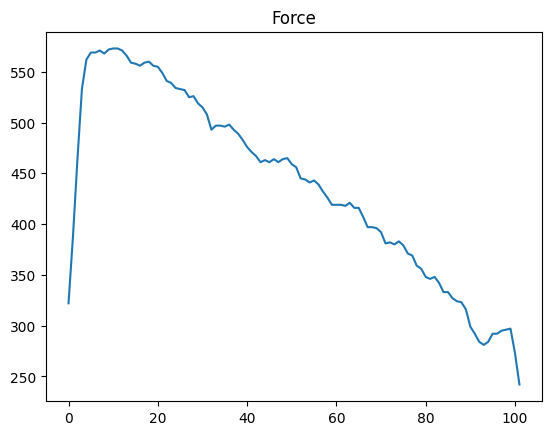

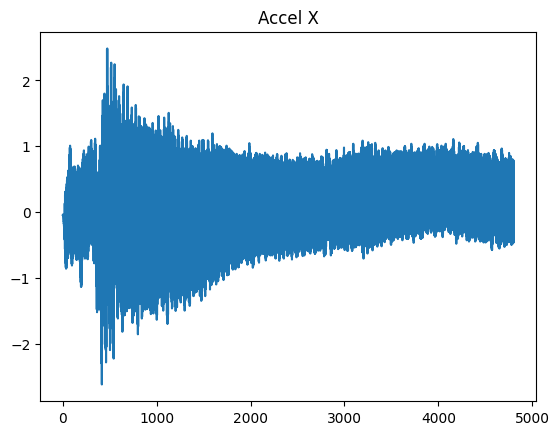

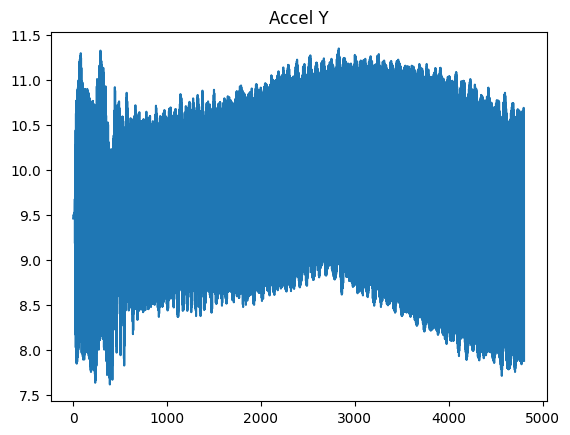

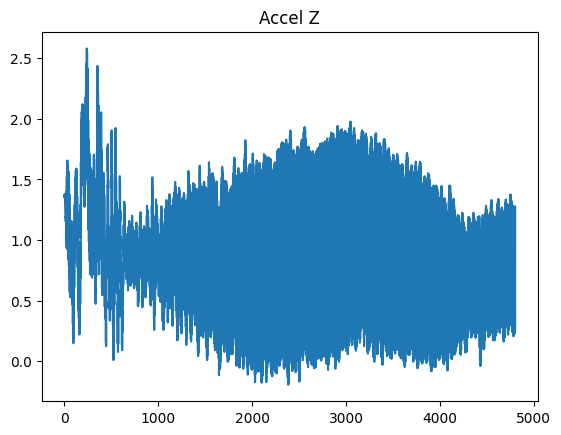

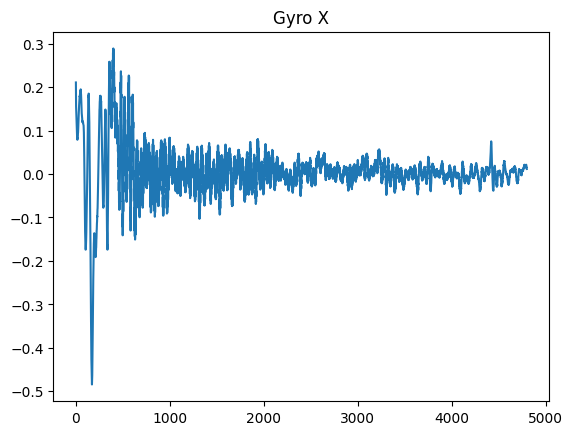

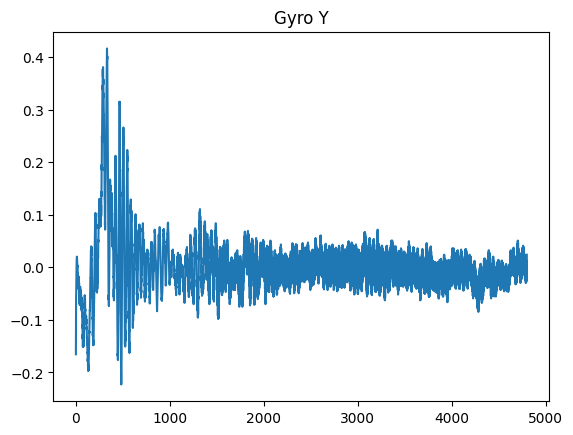

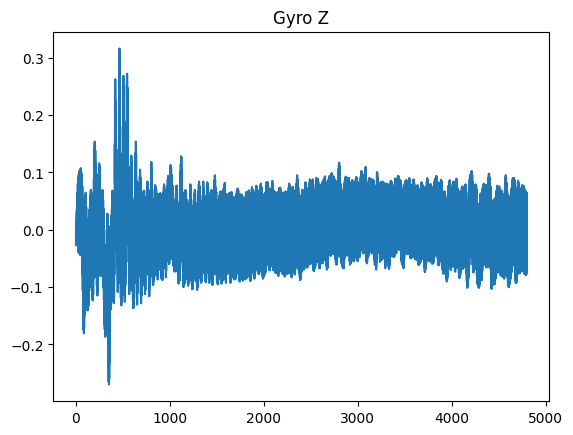

In [169]:
index = 7
print(len(fullgrip_df['Accel X'][index]))
print(len(fullgrip_df['FSR Force List'][index]))

plt.title("Force")
plt.plot(fullgrip_df['FSR Force List'][index])
plt.show()

plt.title("Accel X")
plt.plot(fullgrip_df['Accel X'][index])
plt.show()

plt.title("Accel Y")
plt.plot(fullgrip_df['Accel Y'][index])
plt.show()

plt.title("Accel Z")
plt.plot(fullgrip_df['Accel Z'][index])
plt.show()

plt.title("Gyro X")
plt.plot(fullgrip_df['Gyro X'][index])
plt.show()

plt.title("Gyro Y")
plt.plot(fullgrip_df['Gyro Y'][index])
plt.show()

plt.title("Gyro Z")
plt.plot(fullgrip_df['Gyro Z'][index])
plt.show()
# plt.plot(fullgrip_df['FSR Force List'][12])#[:-1200])
# plt.show()


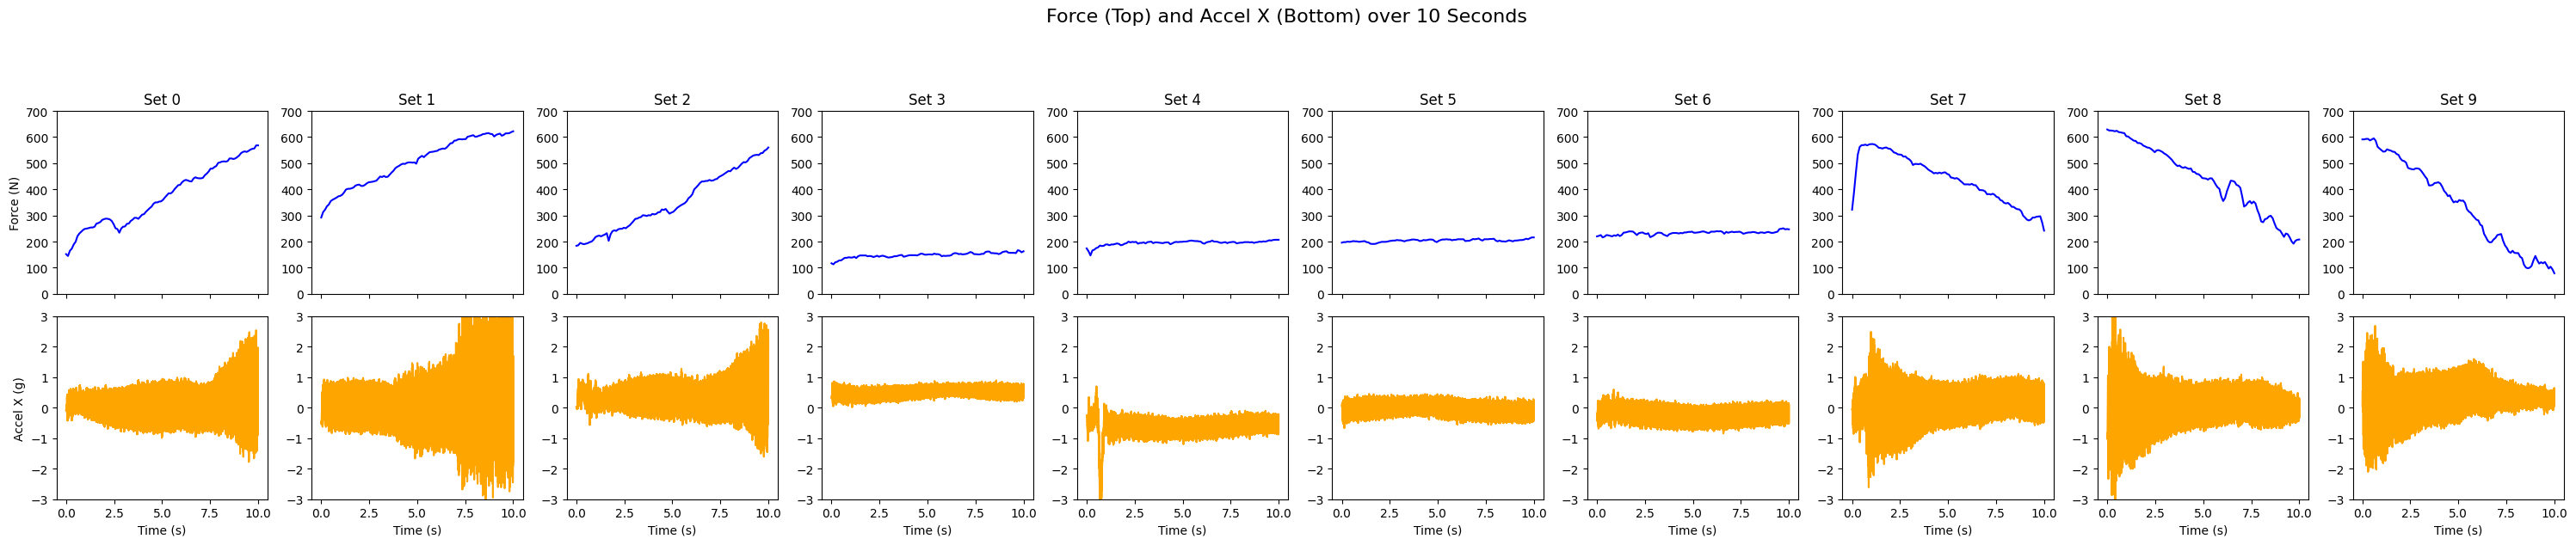

In [166]:
trial = 3
save_dataframe_pickle(fullgrip_df, f"{input_directory}/fullgrip_data_{trial}.pkl")
# save_dataframe_pickle(leather_df, f"{input_directory}/leather_data_{trial}.pkl")
# save_dataframe_pickle(transparent_df, f"{input_directory}/transparent_data_{trial}.pkl")


DataFrame saved as Pickle: experiment3/fullgrip_data_3.pkl


In [167]:
load_dataframe_pickle(f"{input_directory}/fullgrip_data_{trial}.pkl")

DataFrame loaded from Pickle: experiment3/fullgrip_data_3.pkl


,Project Name,Phone Model,Participant ID,Timestamp,Time,Accel X,Accel Y,Accel Z,Gyro X,Gyro Y,Gyro Z,FSR TimeDiff List,FSR Timestamp List,FSR Force List,FSR Timestamp
0,VibroDataCollection,c4a0,gi1,2025-07-15 13:43:27.463,"[1752612207488, 1752612207488, 1752612207488, ...","[-0.08135597, -0.086141616, -0.086141616, -0.0...","[9.456435, 9.446864, 9.466006, 9.475577, 9.489...","[1.3495519, 1.3734802, 1.3830515, 1.3974084, 1...","[0.26480988, 0.1915061, 0.18661919, 0.18173227...","[-0.113926284, -0.025961753, -0.017409647, -0....","[0.0097738365, 0.045203995, 0.050090913, 0.054...","[0.0, 0.025571, 0.081838, 0.147866, 0.260974, ...","[2025_07_15_13_43_27_599969, 2025_07_15_13_43_...","[152.0, 145.0, 165.0, 173.0, 189.0, 199.0, 221...",2025-07-15 13:43:27.599969
1,VibroDataCollection,c4a0,gi2,2025-07-15 13:43:52.468,"[1752612232489, 1752612232492, 1752612232493, ...","[-0.45942193, -0.49292147, -0.526421, -0.54077...","[9.274581, 9.288938, 9.2793665, 9.293723, 9.31...","[0.63170516, 0.5599205, 0.4977071, 0.44506502,...","[0.36254823, 0.36254823, 0.27091852, 0.2464839...","[-0.53420126, -0.53420126, -0.20677772, -0.172...","[-0.11117739, -0.11117739, 0.040317077, 0.0586...","[0.0, 0.028202, 0.091995, 0.172517, 0.260775, ...","[2025_07_15_13_43_52_503634, 2025_07_15_13_43_...","[292.0, 313.0, 322.0, 335.0, 342.0, 355.0, 360...",2025-07-15 13:43:52.503634
2,VibroDataCollection,c4a0,gi3,2025-07-15 13:46:56.837,"[1752612416865, 1752612416865, 1752612416865, ...","[0.02871387, 0.023928227, 0.009571291, 0.00478...","[9.236296, 9.226724, 9.221938, 9.217153, 9.231...","[1.0863415, 1.0289137, 0.9954142, 0.95712906, ...","[0.2035707, 0.170584, 0.16203189, 0.1583667, 0...","[-0.08720095, -0.0151189035, -0.021227552, -0....","[0.0061086477, 0.0012217296, 0.0012217296, -0....","[0.0, 0.032543, 0.083321, 0.150483, 0.27499, 0...","[2025_07_15_13_46_56_869564, 2025_07_15_13_46_...","[184.0, 186.0, 195.0, 192.0, 190.0, 192.0, 194...",2025-07-15 13:46:56.869564
3,VibroDataCollection,c4a0,nh1,2025-07-15 13:49:22.462,"[1752612562485, 1752612562488, 1752612562488, ...","[0.36370903, 0.3493521, 0.32063824, 0.31585258...","[9.533006, 9.52822, 9.523434, 9.509077, 9.5042...","[1.4691931, 1.4261223, 1.3926228, 1.3591232, 1...","[0.1386663, 0.1802051, 0.17776164, 0.17653993,...","[-0.12873976, -0.08842268, -0.085979216, -0.07...","[-0.02687805, 0.032986697, 0.042760536, 0.0513...","[0.0, 0.03498, 0.080918, 0.143104, 0.255654, 0...","[2025_07_15_13_49_22_520692, 2025_07_15_13_49_...","[117.0, 113.0, 121.0, 123.0, 128.0, 128.0, 133...",2025-07-15 13:49:22.520692
4,VibroDataCollection,c4a0,nh2,2025-07-15 13:49:51.920,"[1752612591944, 1752612591944, 1752612591944, ...","[-0.2536392, -0.27756742, -0.3062813, -0.32542...","[9.762716, 9.734002, 9.724431, 9.700503, 9.705...","[1.2921243, 1.282553, 1.2873386, 1.2969099, 1....","[0.091018856, 0.091018856, 0.091018856, 0.0910...","[0.009315688, 0.009315688, 0.009315688, 0.0093...","[-0.02932151, -0.02932151, -0.02932151, -0.029...","[0.0, 0.026668, 0.077667, 0.142991, 0.250202, ...","[2025_07_15_13_49_52_050062, 2025_07_15_13_49_...","[174.0, 163.0, 147.0, 166.0, 169.0, 175.0, 178...",2025-07-15 13:49:52.050062
5,VibroDataCollection,c4a0,nh3,2025-07-15 13:50:18.810,"[1752612618835, 1752612618835, 1752612618835, ...","[0.10049855, 0.086141616, 0.05742774, 0.028713...","[9.7196455, 9.729217, 9.753145, 9.772287, 9.80...","[1.1389836, 1.1150553, 1.119841, 1.1150553, 1....","[0.13133593, 0.13133593, 0.13133593, 0.1313359...","[-0.05299252, -0.05299252, -0.05299252, -0.052...","[0.035430156, 0.035430156, 0.035430156, 0.0354...","[0.0, 0.035907, 0.082656, 0.162127, 0.241577, ...","[2025_07_15_13_50_18_773127, 2025_07_15_13_50_...","[196.0, 198.0, 198.0, 200.0, 199.0, 200.0, 202...",2025-07-15 13:50:18.773127
6,VibroDataCollection,c4a0,nh4,2025-07-15 13:50:47.307,"[1752612647329, 1752612647329, 1752612647329, ...","[-0.19621146, -0.22971097, -0.25842485, -0.301...","[9.753145, 9.734002, 9.743574, 9.762716, 9.781...","[0.823130